# Packages

In [56]:
# Data and Maths
import pandas as pd
import numpy as np
import math

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
import scipy.stats as stats
from scipy.stats import binom, norm
import pymc as pm
import arviz as az
RANDOM_SEED = 42

# Geocoding
import geopandas as gpd
from geopy.geocoders import Nominatim # For folium maps to return centering coordinates
import osmnx as ox # To return the geometry of a target region or city
import ssl # For the certificates to make the osmnx work
ssl._create_default_https_context = ssl._create_unverified_context

# Estimating vehicle adoption in LSOAs

Here, we use 2011 and 2021 census data to adjust vehicle registration data and quantify our uncertainty about the true underlying number of vehicles owned in a particular lower layer super output area (LSOA).

### Load 2011 Census data

In [39]:
census_cars_and_vans_2011_df = pd.read_csv('../../data/demographic_data/census_2011/LSOA_cars_and_vans.csv')
census_cars_and_vans_2011_df.head()

,GEO_CODE,GEO_LABEL,GEO_TYPE,GEO_TYP2,Car or van availability : Total\ Car or van availability - Unit : Households,Car or van availability : Total\ Car or van availability - Unit : Cars or vans,Car or van availability : No cars or vans in household - Unit : Households,Car or van availability : 1 car or van in household - Unit : Households,Car or van availability : 2 cars or vans in household - Unit : Households,Car or van availability : 3 cars or vans in household - Unit : Households,Car or van availability : 4 or more cars or vans in household - Unit : Households,Car or van availability : Sum of all cars or vans - Unit : Cars or vans
0,95AA01S1,Aldergrove_1,Lower Super Output Areas and Data Zones,LSOADZ,310,NaN,23,199,82,3,3,389
1,95AA01S2,Aldergrove_2,Lower Super Output Areas and Data Zones,LSOADZ,624,NaN,44,209,259,72,40,1122
2,95AA01S3,Aldergrove_3,Lower Super Output Areas and Data Zones,LSOADZ,588,NaN,46,219,229,57,37,1012
3,95AA02W1,Balloo,Lower Super Output Areas and Data Zones,LSOADZ,839,NaN,287,392,128,25,7,756
4,95AA03W1,Ballycraigy,Lower Super Output Areas and Data Zones,LSOADZ,845,NaN,293,399,129,22,2,731


In [40]:
# Filter for relevant columns
census_cars_and_vans_2011_df = census_cars_and_vans_2011_df[['GEO_CODE', 'GEO_LABEL', 'Car or van availability : Sum of all cars or vans - Unit : Cars or vans']]

# Rename columns
census_cars_and_vans_2011_df = census_cars_and_vans_2011_df.rename(
    columns={
        'GEO_CODE':'LSOA11CD',
        'GEO_LABEL':'LSOA11NM',
        'Car or van availability : Sum of all cars or vans - Unit : Cars or vans':'number_of_cars'
    }
)

# Set index to LSOA11CD
census_cars_and_vans_2011_df = census_cars_and_vans_2011_df.set_index('LSOA11CD', drop=False)

# Set index name to None
census_cars_and_vans_2011_df.index.name = None

census_cars_and_vans_2011_df.head()

,LSOA11CD,LSOA11NM,number_of_cars
95AA01S1,95AA01S1,Aldergrove_1,389
95AA01S2,95AA01S2,Aldergrove_2,1122
95AA01S3,95AA01S3,Aldergrove_3,1012
95AA02W1,95AA02W1,Balloo,756
95AA03W1,95AA03W1,Ballycraigy,731


### Load 2021 Census data

In [41]:
raw_census_cars_and_vans_2021_df = pd.read_csv('../../data/demographic_data/census_2021/LSOA_car_or_van_availability.csv')
raw_census_cars_and_vans_2021_df.head(10)

,Lower Layer Super Output Areas Code,Lower Layer Super Output Areas,Car or van availability (5 categories) Code,Car or van availability (5 categories),Observation
0,E01000001,City of London 001A,-8,Does not apply,0
1,E01000001,City of London 001A,0,No cars or vans in household,555
2,E01000001,City of London 001A,1,1 car or van in household,243
3,E01000001,City of London 001A,2,2 cars or vans in household,29
4,E01000001,City of London 001A,3,3 or more cars or vans in household,10
5,E01000002,City of London 001B,-8,Does not apply,0
6,E01000002,City of London 001B,0,No cars or vans in household,578
7,E01000002,City of London 001B,1,1 car or van in household,208
8,E01000002,City of London 001B,2,2 cars or vans in household,26
9,E01000002,City of London 001B,3,3 or more cars or vans in household,12


In [42]:
# Since each availability code corresponds to the number of vehicles present at the recorded household, 
# the number of cars and vans present in the LSOA can be approximated as the number of households that fall into a category, multiplied by the category code.
raw_census_cars_and_vans_2021_df['number_of_cars'] = raw_census_cars_and_vans_2021_df['Observation'] * raw_census_cars_and_vans_2021_df['Car or van availability (5 categories) Code']

# Create a new compacted dataframe with the columns of interest
census_cars_and_vans_2021_df = pd.DataFrame(index=raw_census_cars_and_vans_2021_df['Lower Layer Super Output Areas Code'].unique(), columns = ['LSOA21NM', 'number_of_cars'])

# Populate columns
census_cars_and_vans_2021_df['LSOA21NM'] = raw_census_cars_and_vans_2021_df['Lower Layer Super Output Areas'].unique()
census_cars_and_vans_2021_df['number_of_cars'] = raw_census_cars_and_vans_2021_df.groupby('Lower Layer Super Output Areas Code')['number_of_cars'].sum()
census_cars_and_vans_2021_df['LSOA21CD'] = census_cars_and_vans_2021_df.index

census_cars_and_vans_2021_df.head()

,LSOA21NM,number_of_cars,LSOA21CD
E01000001,City of London 001A,331,E01000001
E01000002,City of London 001B,296,E01000002
E01000003,City of London 001C,220,E01000003
E01000005,City of London 001E,119,E01000005
E01000006,Barking and Dagenham 016A,516,E01000006


### Filter data for local authority district (LAD)

By restricting the area of interest, this speeds up the development of the modelling and analysis.

In [43]:
# Define LAD of interest
LAD = 'Bath and North East Somerset'

# Load LSOA lookup tables to help map LSOAs to LADs as well as map between 2011 and 2021 LSOA codes.
lsoa_lookup = pd.read_csv('../../data/spatial_data/lsoa_data/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv')
lsoa_lookup.head()

,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,CHGIND,LAD22CD,LAD22NM,LAD22NMW,ObjectId
0,E01000001,City of London 001A,E01000001,City of London 001A,U,E09000001,City of London,NaN,1
1,E01000002,City of London 001B,E01000002,City of London 001B,U,E09000001,City of London,NaN,2
2,E01000003,City of London 001C,E01000003,City of London 001C,U,E09000001,City of London,NaN,3
3,E01000005,City of London 001E,E01000005,City of London 001E,U,E09000001,City of London,NaN,4
4,E01000006,Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,U,E09000002,Barking and Dagenham,NaN,5


In [44]:
# Filter lookup table for LSOA within the target LAD only
lad_lsoa_lookup = lsoa_lookup[lsoa_lookup['LAD22NM'] == LAD]
lad_lsoa_lookup.head()

,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,CHGIND,LAD22CD,LAD22NM,LAD22NMW,ObjectId
13651,E01014373,Bath and North East Somerset 010A,E01014373,Bath and North East Somerset 010A,U,E06000022,Bath and North East Somerset,NaN,13652
13652,E01014428,Bath and North East Somerset 008B,E01014428,Bath and North East Somerset 008B,U,E06000022,Bath and North East Somerset,NaN,13653
13676,E01014479,Bath and North East Somerset 005C,E01014479,Bath and North East Somerset 005C,U,E06000022,Bath and North East Somerset,NaN,13677
13678,E01014429,Bath and North East Somerset 008C,E01014429,Bath and North East Somerset 008C,U,E06000022,Bath and North East Somerset,NaN,13679
13681,E01014374,Bath and North East Somerset 010B,E01014374,Bath and North East Somerset 010B,U,E06000022,Bath and North East Somerset,NaN,13682


In [45]:
# Merge census cars and van data with the filtered LSOA lookup data
lad_census_cars_vans_2021_df = census_cars_and_vans_2021_df.merge(lad_lsoa_lookup[['LSOA11CD', 'LSOA21CD']], on='LSOA21CD', how='right')

# Some new LSOAs were fromed in 2021 due to changes in population sizes. Many of these new 2021 LSOAs are a result of dividing a 2011 LSOA into two new LSOAs.
# Since the 2021 LSOAs share the same 2011 LSOA code, we sum their values. 
# This is easier than going the other way and mapping 2011 LSOAs to 2021 LSOAs
lad_census_cars_vans_2021_df['number_of_cars'] = lad_census_cars_vans_2021_df.groupby('LSOA11CD')['number_of_cars'].transform('sum')

# Drop duplicate LSOAs
lad_census_cars_vans_2021_df = lad_census_cars_vans_2021_df.drop_duplicates(subset=['LSOA11CD']).drop(columns=['LSOA21CD'])

# Set index to LSOA11CD
lad_census_cars_vans_2021_df = lad_census_cars_vans_2021_df.set_index('LSOA11CD', drop=False)

lad_census_cars_vans_2021_df.head()

,LSOA21NM,number_of_cars,LSOA11CD
LSOA11CD,,,
E01014373,Bath and North East Somerset 010A,863,E01014373
E01014428,Bath and North East Somerset 008B,663,E01014428
E01014479,Bath and North East Somerset 005C,741,E01014479
E01014429,Bath and North East Somerset 008C,776,E01014429
E01014374,Bath and North East Somerset 010B,895,E01014374


In [46]:
# Filter LSOAs that are contained within the target LAD
lad_census_cars_vans_2011_df = census_cars_and_vans_2011_df.loc[lad_lsoa_lookup['LSOA11CD'].values]

# Drop duplicate LSOAs
lad_census_cars_vans_2011_df = lad_census_cars_vans_2011_df.drop_duplicates(subset=['LSOA11CD'])

# Set index to LSOA11CD
lad_census_cars_vans_2011_df = lad_census_cars_vans_2011_df.set_index('LSOA11CD', drop=False)

lad_census_cars_vans_2011_df.head()

,LSOA11CD,LSOA11NM,number_of_cars
LSOA11CD,,,
E01014373,E01014373,Bath and North East Somerset 010A,825
E01014428,E01014428,Bath and North East Somerset 008B,727
E01014479,E01014479,Bath and North East Somerset 005C,804
E01014429,E01014429,Bath and North East Somerset 008C,761
E01014374,E01014374,Bath and North East Somerset 010B,796


### Load vehicle registration data

This data is from the UK Department for Transport.

In [47]:
# apply_dtypes is a convenience function that converts select columns from str to float values
def apply_dtypes(first, last):
    dtypes = {i: str for i in range(first)}  # first 'first' columns as strings
    dtypes.update({i: float for i in range(first, last)}) # 'last' columns is currently hard coded. Float is needed for NaNs
    return dtypes

Car registration data

In [48]:
car_registrations_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0125.csv', dtype = apply_dtypes(5, 57), na_values=['[c]', '[x]'])
    .query("BodyType == 'Cars' & Keepership == 'Private' & LicenceStatus == 'Licensed'") # Filter for liscenced, private cars
    .drop(columns = ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD] # Filter for target Local Authority District
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
car_registrations_lsoa = car_registrations_lsoa[~car_registrations_lsoa.index.duplicated(keep='first')]

car_registrations_lsoa.head()

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,359.0,361.0,353.0,357.0,352.0,369.0,390.0,382.0,380.0,371.0,...,390.0,397.0,391.0,393.0,384.0,389.0,406.0,378.0,384.0,386.0
E01014371,509.0,502.0,512.0,507.0,524.0,517.0,524.0,524.0,530.0,523.0,...,537.0,552.0,546.0,557.0,552.0,540.0,538.0,549.0,547.0,557.0
E01014372,494.0,495.0,507.0,506.0,509.0,513.0,508.0,506.0,508.0,500.0,...,548.0,553.0,556.0,552.0,571.0,561.0,588.0,604.0,595.0,591.0
E01014373,762.0,753.0,754.0,770.0,768.0,775.0,762.0,773.0,740.0,749.0,...,680.0,674.0,690.0,688.0,695.0,692.0,684.0,696.0,692.0,703.0
E01014374,740.0,752.0,762.0,759.0,756.0,746.0,750.0,741.0,739.0,727.0,...,632.0,627.0,632.0,637.0,634.0,633.0,637.0,628.0,627.0,641.0


Other vehicle body types (excl. Motorbikes) registration data

In [49]:
other_registrations_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0125.csv', dtype = apply_dtypes(5, 57), na_values=['[c]', '[x]'])
    .query("BodyType == 'Other body types' & Keepership == 'Private' & LicenceStatus == 'Licensed'")
    .drop(columns = ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD] # Filter for target Local Authority District
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
other_registrations_lsoa = other_registrations_lsoa[~other_registrations_lsoa.index.duplicated(keep='first')]

other_registrations_lsoa.head()

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,32.0,29.0,30.0,30.0,32.0,30.0,35.0,36.0,34.0,37.0,...,40.0,40.0,42.0,41.0,36.0,43.0,40.0,38.0,39.0,40.0
E01014371,24.0,22.0,22.0,20.0,22.0,21.0,21.0,22.0,25.0,29.0,...,25.0,24.0,26.0,25.0,28.0,29.0,27.0,26.0,26.0,28.0
E01014372,17.0,18.0,20.0,22.0,18.0,21.0,22.0,25.0,26.0,31.0,...,43.0,41.0,42.0,43.0,41.0,43.0,46.0,43.0,41.0,39.0
E01014373,103.0,105.0,110.0,109.0,106.0,105.0,108.0,109.0,102.0,111.0,...,97.0,93.0,90.0,91.0,92.0,96.0,96.0,99.0,95.0,95.0
E01014374,65.0,65.0,64.0,68.0,65.0,64.0,61.0,64.0,62.0,64.0,...,42.0,41.0,43.0,45.0,47.0,46.0,48.0,50.0,48.0,46.0


In [50]:
# Combine both car registrations and other body type registrations
registered_vehicles_lsoa = car_registrations_lsoa + other_registrations_lsoa
registered_vehicles_lsoa.head()

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,391.0,390.0,383.0,387.0,384.0,399.0,425.0,418.0,414.0,408.0,...,430.0,437.0,433.0,434.0,420.0,432.0,446.0,416.0,423.0,426.0
E01014371,533.0,524.0,534.0,527.0,546.0,538.0,545.0,546.0,555.0,552.0,...,562.0,576.0,572.0,582.0,580.0,569.0,565.0,575.0,573.0,585.0
E01014372,511.0,513.0,527.0,528.0,527.0,534.0,530.0,531.0,534.0,531.0,...,591.0,594.0,598.0,595.0,612.0,604.0,634.0,647.0,636.0,630.0
E01014373,865.0,858.0,864.0,879.0,874.0,880.0,870.0,882.0,842.0,860.0,...,777.0,767.0,780.0,779.0,787.0,788.0,780.0,795.0,787.0,798.0
E01014374,805.0,817.0,826.0,827.0,821.0,810.0,811.0,805.0,801.0,791.0,...,674.0,668.0,675.0,682.0,681.0,679.0,685.0,678.0,675.0,687.0


To compare vehicle registrations and census data taken in the same year, we take a mean of the four quarters for the vehicle registration data.

In [51]:
lad_census_cars_vans_2011_df['registered_vehicles'] = registered_vehicles_lsoa.loc[:, ['2011 Q1', '2011 Q2', '2011 Q3', '2011 Q4']].mean(axis=1).round()
lad_census_cars_vans_2011_df.head()

,LSOA11CD,LSOA11NM,number_of_cars,registered_vehicles
LSOA11CD,,,,
E01014373,E01014373,Bath and North East Somerset 010A,825,778.0
E01014428,E01014428,Bath and North East Somerset 008B,727,634.0
E01014479,E01014479,Bath and North East Somerset 005C,804,714.0
E01014429,E01014429,Bath and North East Somerset 008C,761,727.0
E01014374,E01014374,Bath and North East Somerset 010B,796,676.0


In [52]:
lad_census_cars_vans_2021_df['registered_vehicles'] = registered_vehicles_lsoa.loc[:, ['2021 Q1', '2021 Q2', '2021 Q3', '2021 Q4']].mean(axis=1).round()
lad_census_cars_vans_2021_df.head()

,LSOA21NM,number_of_cars,LSOA11CD,registered_vehicles
LSOA11CD,,,,
E01014373,Bath and North East Somerset 010A,863,E01014373,868.0
E01014428,Bath and North East Somerset 008B,663,E01014428,630.0
E01014479,Bath and North East Somerset 005C,741,E01014479,724.0
E01014429,Bath and North East Somerset 008C,776,E01014429,736.0
E01014374,Bath and North East Somerset 010B,895,E01014374,807.0


### Plot Census vs Registration Data

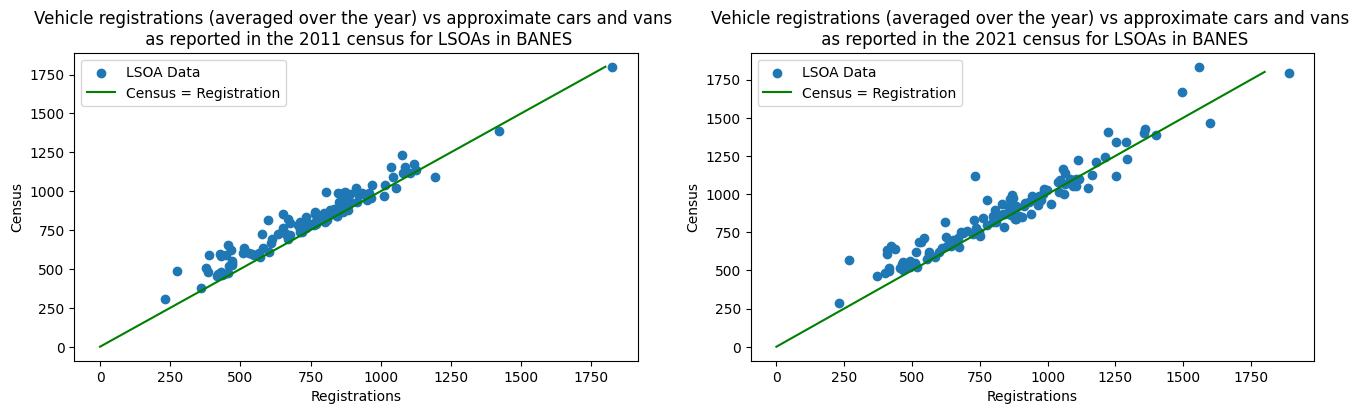

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# 2011
ax[0].scatter(x=lad_census_cars_vans_2011_df['registered_vehicles'], y=lad_census_cars_vans_2011_df['number_of_cars'], label='LSOA Data')
ax[0].plot(np.linspace(0, 1800), np.linspace(0, 1800), color='green', label='Census = Registration')
ax[0].set_xlabel('Registrations')
ax[0].set_ylabel('Census')
ax[0].set_title('Vehicle registrations (averaged over the year) vs approximate cars and vans \n as reported in the 2011 census for LSOAs in BANES')
ax[0].legend()

# 2021
ax[1].scatter(x=lad_census_cars_vans_2021_df['registered_vehicles'], y=lad_census_cars_vans_2021_df['number_of_cars'], label='LSOA Data')
ax[1].plot(np.linspace(0, 1800), np.linspace(0, 1800), color='green', label='Census = Registration')
ax[1].set_xlabel('Registrations')
ax[1].set_ylabel('Census')
ax[1].set_title('Vehicle registrations (averaged over the year) vs approximate cars and vans \n as reported in the 2021 census for LSOAs in BANES')

ax[1].legend()
plt.show()

### Calculate the relative difference between census data and vehicle registration data

This is the difference relative to the vehicle registration data. How much larger or smaller is the census data, relative to the number of vehicle registrations?

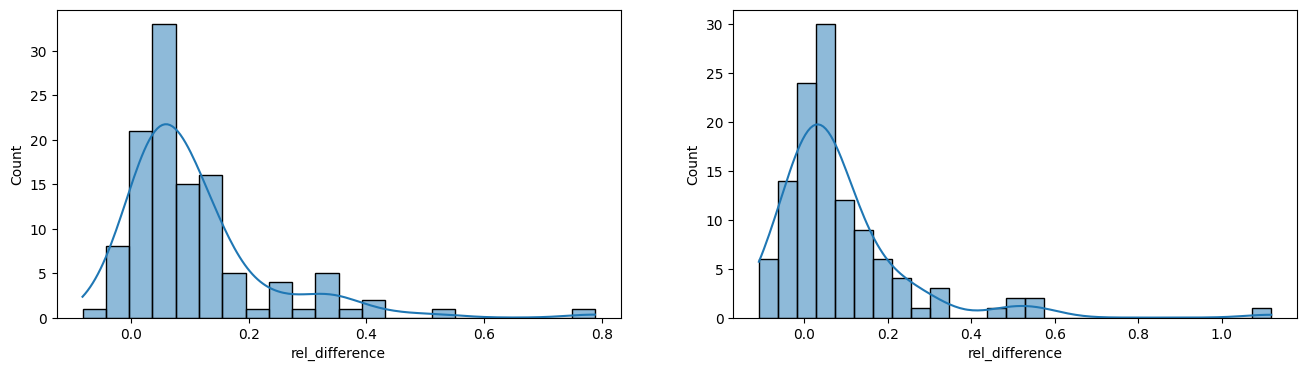

In [54]:
# Calculate the absolute differences for 2011 and 2021
lad_census_cars_vans_2011_df['abs_difference'] = lad_census_cars_vans_2011_df['number_of_cars'] - lad_census_cars_vans_2011_df['registered_vehicles']
lad_census_cars_vans_2021_df['abs_difference'] = lad_census_cars_vans_2021_df['number_of_cars'] - lad_census_cars_vans_2021_df['registered_vehicles']

# Use the absolute difference to calculate the relative differences
lad_census_cars_vans_2011_df['rel_difference'] = lad_census_cars_vans_2011_df['abs_difference'] / lad_census_cars_vans_2011_df['registered_vehicles']
lad_census_cars_vans_2021_df['rel_difference'] = lad_census_cars_vans_2021_df['abs_difference'] / lad_census_cars_vans_2021_df['registered_vehicles']

fig, ax = plt.subplots(1, 2, figsize=(16,4))

sns.histplot(ax = ax[0], data = lad_census_cars_vans_2011_df['rel_difference'], kde=True)
sns.histplot(ax = ax[1], data = lad_census_cars_vans_2021_df['rel_difference'], kde=True)
plt.show()

### Model the relative difference with PyMC

In [55]:
# Create DataFrames from the Series
rel_diff_2011 = pd.DataFrame({'LSOA11CD': lad_census_cars_vans_2011_df['rel_difference'].index, 'year': 2011, 'rel_diff': lad_census_cars_vans_2011_df['rel_difference'].values})
rel_diff_2021 = pd.DataFrame({'LSOA11CD': lad_census_cars_vans_2021_df['rel_difference'].index, 'year': 2021, 'rel_diff': lad_census_cars_vans_2021_df['rel_difference'].values})

# Concatenate the two DataFrames
rel_diff = pd.concat([rel_diff_2011, rel_diff_2021], ignore_index=True).sort_values(by='LSOA11CD').reset_index(drop=True)
rel_diff.head()

,LSOA11CD,year,rel_diff
0,E01014370,2021,0.205314
1,E01014370,2011,0.116009
2,E01014371,2021,0.304029
3,E01014371,2011,0.250865
4,E01014372,2021,0.289474


In [61]:
coords = {"LSOA": rel_diff.LSOA11CD.unique().tolist()}
lsoa = np.repeat(np.arange(len(rel_diff.LSOA11CD.unique())), 2)

In [62]:
with pm.Model(coords=coords) as hierarchical_model:
    lsoa_idx = pm.MutableData("lsoa_idx", lsoa, dims="obs_id")
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0, sigma=1)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    
    # Random intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, dims='LSOA')

    # Model error
    sigma_y = pm.Exponential("sigma_y", 0.5)

    # Expected value
    y_hat = alpha[lsoa_idx]
    
    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=rel_diff.rel_diff.values, dims="obs_id")

# Sample from the model
with hierarchical_model:
    trace = pm.sample(2000, tune=1000, cores=4, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, alpha, sigma_y]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'mu_a'}>,
        <Axes: title={'center': 'mu_a'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_y'}>,
        <Axes: title={'center': 'sigma_y'}>]], dtype=object)

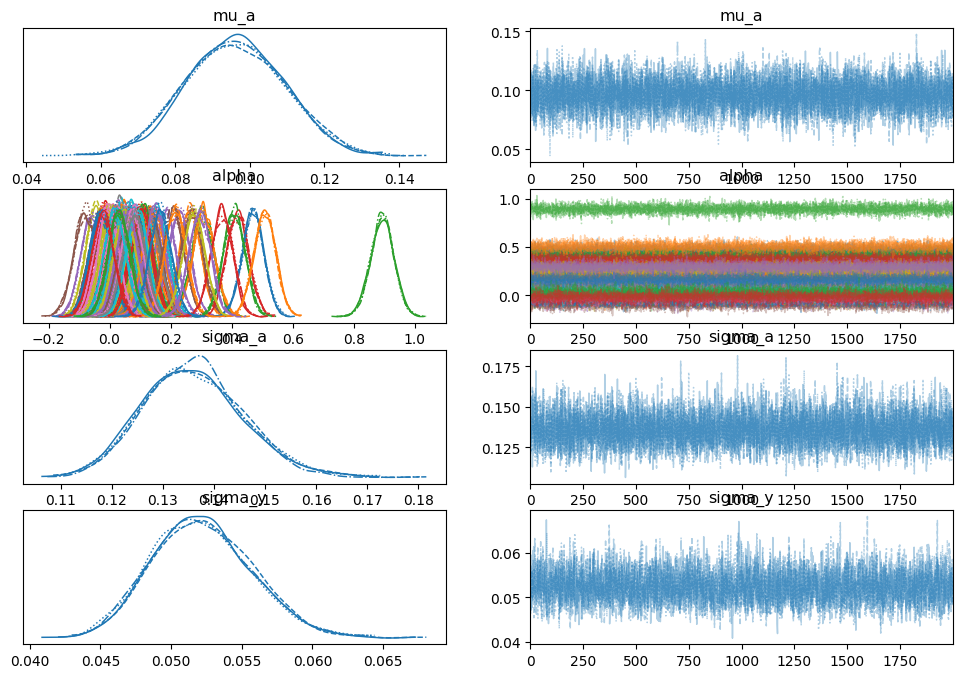

In [63]:
az.plot_trace(trace)

Text(0, 0.5, 'alpha')

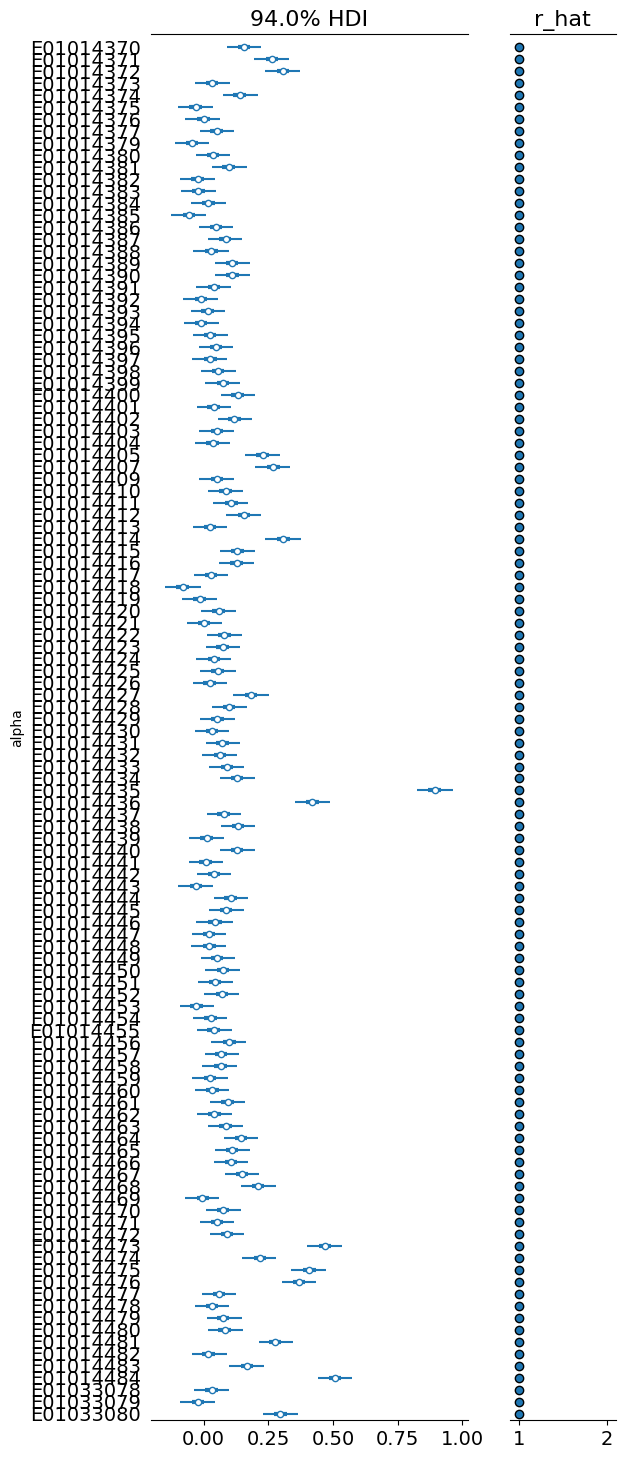

In [64]:
ax = pm.plot_forest(
    trace,
    var_names=["alpha"],
    figsize=(6, 18),
    combined=True,
    r_hat=True,
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha")

In [292]:
target_lsoa = rel_diff.LSOA11CD.unique()[3]
target_lsoa

'E01014373'

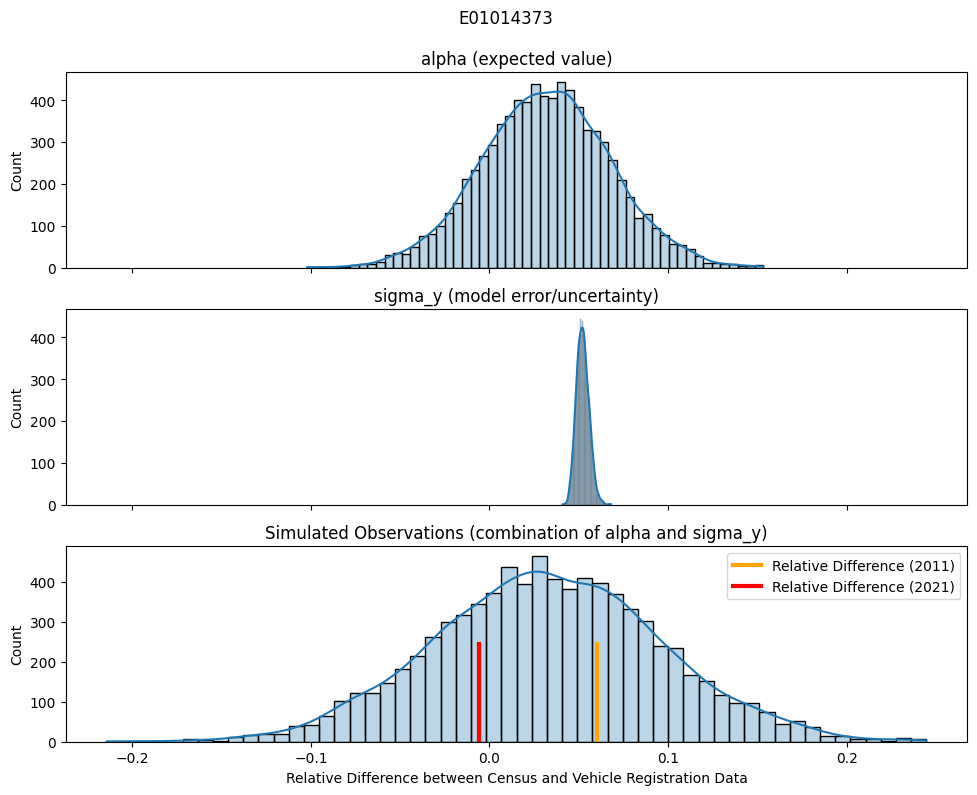

In [293]:
alpha = trace.posterior.sel(LSOA=target_lsoa).alpha.stack(combined=('chain', 'draw')).to_numpy()
sigma_y = trace.posterior.sel(LSOA=target_lsoa).sigma_y.stack(combined=('chain', 'draw')).to_numpy()
simulated_observations = alpha + np.random.normal(0, sigma_y)

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
fig.suptitle(target_lsoa)
fig.tight_layout(pad=2.0)
plt.xlabel('Relative Difference between Census and Vehicle Registration Data')

sns.histplot(alpha, kde=True, ax=axes[0], alpha=0.3)
axes[0].set_title('alpha (expected value)')

sns.histplot(sigma_y, kde=True, ax=axes[1], alpha=0.3)
axes[1].set_title('sigma_y (model error/uncertainty)')

sns.histplot(simulated_observations, kde=True, ax=axes[2], alpha=0.3)
axes[2].set_title('Simulated Observations (combination of alpha and sigma_y)')
axes[2].axvline(rel_diff.loc[rel_diff['LSOA11CD'] == target_lsoa, 'rel_diff'].values[0], 0, 0.5, color='orange', linewidth=3, label='Relative Difference (2011)')
axes[2].axvline(rel_diff.loc[rel_diff['LSOA11CD'] == target_lsoa, 'rel_diff'].values[1], 0, 0.5, color='red', linewidth=3, label='Relative Difference (2021)')

plt.legend()
plt.show()

Use this to adjust estimates for the number of vehicles owned in a particular LSOA

[]

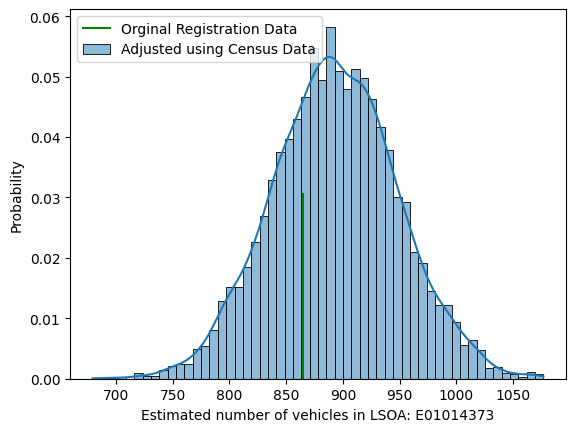

In [294]:
sns.histplot(registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'] * (1 + simulated_observations), kde=True, label='Adjusted using Census Data', stat='probability')
plt.axvline(registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'], 0, 0.5, color='green', label='Orginal Registration Data')
plt.xlabel('Estimated number of vehicles in LSOA: {}'.format(target_lsoa))
plt.legend()
plt.plot()

# Estimating EV adoption in LSOAs

### Convenience Functions

In [295]:
# mask is a way of filtering a dataframe in a chained way
def mask(df, key, value):
    return df[df[key] == value]

pd.DataFrame.mask = mask

# apply_dtypes converts select columns from str to float values
def apply_dtypes(first, last):
    dtypes = {i: str for i in range(first)}  # first 'first' columns as strings
    dtypes.update({i: float for i in range(first, last)}) # 'last' columns is currently hard coded. Float is needed for NaNs
    return dtypes

# Returns the first (and oldest) date (assuming date is the index) of a series or DataFrame
def calculate_t0(data):
    year = int(data.head(1).index[0][:4])
    quarter = data.head(1).index[0][-2:]
    if quarter == 'Q1':
        t0 = year + 0
    elif quarter == 'Q2':
        t0 = year + 0.25
    elif quarter == 'Q3':
        t0 = year + 0.5
    elif quarter == 'Q4':
        t0 = year + 0.75
    return t0

# Returns the last (and most recent) date (assuming date is the index) of a series or DataFrame
def calculate_t_present(data):
    year = int(data.tail(1).index[0][:4])
    quarter = data.tail(1).index[0][-2:]
    if quarter == 'Q1':
        t_present = year + 0
    elif quarter == 'Q2':
        t_present = year + 0.25
    elif quarter == 'Q3':
        t_present = year + 0.5
    elif quarter == 'Q4':
        t_present = year + 0.75    
    return t_present

# Returns an array of numeric dates between t0 and t1 at a specified sample rate
def calculate_date_range(t0, t1, sample_rate):
    return np.linspace(t0, t1, int((t1-t0)*sample_rate) + 1)

# Takes in text based dates (e.g. 2022 Q4) and returns an array of decimalised dates
def convert_dates_to_numeric(data):
    dates = np.zeros(len(data))
    for i in np.arange(len(data)):
        year = int(data.index[i][:4])
        quarter = data.index[i][-2:]
        if quarter == 'Q1':
            d = year + 0
        elif quarter == 'Q2':
            d = year + 0.25
        elif quarter == 'Q3':
            d = year + 0.5
        elif quarter == 'Q4':
            d = year + 0.75
        dates[i] = d
    return dates

### Load EV registration data

In [296]:
ev_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0145.csv', dtype = apply_dtypes(4, 56), na_values=['[c]', '[x]'])
    .query("Keepership == 'Private'")
    .drop(columns = ['Keepership', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD]
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

ev_lsoa.head()

,Fuel,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,Battery electric,10.0,9.0,8.0,7.0,8.0,8.0,6.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014370,Plug-in hybrid electric (petrol),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014370,Total,14.0,13.0,12.0,10.0,11.0,11.0,8.0,6.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,Battery electric,8.0,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014371,Plug-in hybrid electric (diesel),NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [297]:
bev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Battery electric' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
bev_lsoa = bev_lsoa[~bev_lsoa.index.duplicated(keep='first')]

bev_lsoa.head()

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,10.0,9.0,8.0,7.0,8.0,8.0,6.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014371,8.0,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,8.0,7.0,5.0,5.0,5.0,NaN,5.0,5.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,13.0,10.0,12.0,11.0,11.0,11.0,9.0,7.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,20.0,20.0,17.0,18.0,18.0,15.0,15.0,10.0,8.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [298]:
phev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Plug-in hybrid electric (petrol)' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
phev_lsoa = phev_lsoa[~phev_lsoa.index.duplicated(keep='first')]

phev_lsoa.head()

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,6.0,5.0,NaN,NaN,NaN,NaN,6.0,5.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,11.0,12.0,11.0,10.0,9.0,8.0,7.0,5.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Interpolate missing registration data

In [299]:
# Interpolates missing registration data
def interpolate_registration_data(data, sample_rate):
    def interpolate_col(col):
        dates = calculate_date_range(calculate_t0(col), calculate_t_present(col), sample_rate)
        mask = ~col.isna().values
        if mask.any():
            xp = dates[mask]
            fp = col[mask]
            x = dates
            interpolated = np.round(np.interp(x, xp, fp))
            return pd.Series(data=interpolated, index=col.index)
        else:
            return pd.Series(data=np.nan, index=col.index)
    
    interpolated_df = data.apply(interpolate_col, axis=0)

    interpolated_df = interpolated_df.fillna(0)
    
    return interpolated_df

In [300]:
sample_rate = 4 # Quarterly

bev_lsoa_i = interpolate_registration_data(bev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
phev_lsoa_i = interpolate_registration_data(phev_lsoa.T.iloc[::-1], sample_rate=sample_rate)

### Sample from model posterial distribution and simulate plausable observations

[]

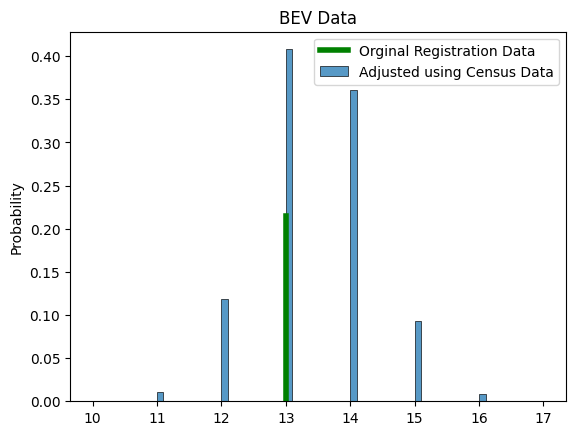

In [301]:
alpha = trace.posterior.sel(LSOA=target_lsoa).alpha.stack(combined=('chain', 'draw')).to_numpy()
sigma_y = trace.posterior.sel(LSOA=target_lsoa).sigma_y.stack(combined=('chain', 'draw')).to_numpy()
simulated_observations = alpha + np.random.normal(0, sigma_y)

sns.histplot((bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)).round(0), label='Adjusted using Census Data', stat='probability')
plt.axvline(bev_lsoa_i.loc['2023 Q1', target_lsoa], 0, 0.5, color='green', label='Orginal Registration Data', linewidth=4)
plt.legend()
plt.title('BEV Data')
plt.plot()

# Estimating on-plot parking access in LSOAs

### Load housing and accommodation data

In [302]:
house_lsoa = (
    pd.read_csv('../../data/demographic_data/census_2021/LSOA_households.csv')
    .rename(columns={'Lower layer Super Output Areas Code':'LSOA21CD', 'Lower layer Super Output Areas':'LSOA21NM', 'Observation':'N_households'})
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LSOA21CD', 'LAD22NM']], on = 'LSOA21CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD]
    .drop(columns=['LAD22NM', 'LSOA21NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
house_lsoa = house_lsoa[~house_lsoa.index.duplicated(keep='first')]

house_lsoa.head()

,LSOA21CD,N_households
LSOA11CD,,
E01014370,E01014370,1009
E01014371,E01014371,1044
E01014372,E01014372,1043
E01014373,E01014373,659
E01014374,E01014374,666


In [303]:
accommodation_type_lsoa = (
    pd.read_csv('../../data/demographic_data/census_2021/LSOA_accommodation_type.csv')
    .rename(columns={'Lower layer Super Output Areas Code':'LSOA21CD', 'Lower layer Super Output Areas':'LSOA21NM', 'Accommodation type (8 categories)':'Accommodation_type'})
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LSOA21CD', 'LAD22NM']], on = 'LSOA21CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD]
    .drop(columns=['LAD22NM', 'LSOA21NM', 'Accommodation type (8 categories) Code'])
    .set_index('LSOA11CD')
)

accommodation_type_lsoa.head()

,LSOA21CD,Accommodation_type,Observation
LSOA11CD,,,
E01014370,E01014370,Detached,15
E01014370,E01014370,Semi-detached,35
E01014370,E01014370,Terraced,61
E01014370,E01014370,In a purpose-built block of flats or tenement,507
E01014370,E01014370,"Part of a converted or shared house, including...",134


### Reformat accommodation type data

In [304]:
accommodation_type_lsoa.Accommodation_type.unique()

array(['Detached', 'Semi-detached', 'Terraced',
       'In a purpose-built block of flats or tenement',
       'Part of a converted or shared house, including bedsits',
       'Part of another converted building, for example, former school, church or warehouse',
       'In a commercial building, for example, in an office building, hotel or over a shop',
       'A caravan or other mobile or temporary structure'], dtype=object)

In [305]:
detached_lsoa = accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'Detached']['Observation']
detached_lsoa.name = 'detached'

semi_detached_lsoa = accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'Semi-detached']['Observation']
semi_detached_lsoa.name = 'semi_detached'

terraced_lsoa = accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'Terraced']['Observation']
terraced_lsoa.name = 'terraced'

purpose_built_flat_lsoa = accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'In a purpose-built block of flats or tenement']['Observation']
purpose_built_flat_lsoa.name = 'purpose_built_flat'

converted_flat_lsoa = (accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'Part of a converted or shared house, including bedsits']['Observation'] +
                        accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'Part of another converted building, for example, former school, church or warehouse']['Observation'] +
                        accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'In a commercial building, for example, in an office building, hotel or over a shop']['Observation']
)
converted_flat_lsoa.name = 'converted_flat'

accommodation_type_proportions_lsoa = pd.concat([detached_lsoa, semi_detached_lsoa, terraced_lsoa, purpose_built_flat_lsoa, converted_flat_lsoa], axis=1)
accommodation_type_proportions_lsoa = accommodation_type_proportions_lsoa.div(accommodation_type_proportions_lsoa.sum(axis=1), axis=0)

# Drop duplicate rows
accommodation_type_proportions_lsoa = accommodation_type_proportions_lsoa[~accommodation_type_proportions_lsoa.index.duplicated(keep='first')]

accommodation_type_lsoa = round(accommodation_type_proportions_lsoa.mul(house_lsoa['N_households'], axis=0))
accommodation_type_lsoa['total'] = accommodation_type_lsoa.sum(axis=1)
accommodation_type_lsoa.head()

,detached,semi_detached,terraced,purpose_built_flat,converted_flat,total
LSOA11CD,,,,,,
E01014370,15.0,35.0,61.0,507.0,391.0,1009.0
E01014371,17.0,46.0,71.0,354.0,556.0,1044.0
E01014372,13.0,19.0,152.0,283.0,576.0,1043.0
E01014373,94.0,170.0,337.0,29.0,28.0,658.0
E01014374,232.0,196.0,152.0,62.0,24.0,666.0


### Estimating parking availability by accommodation type

This data is taken from the English Housing Survey 2021.

In the English Housing Survey, there were 1081 end terraces and 1790 mid terraces. 

Ratios are: 0.3765 and 0.6235

In [306]:
on_plot_parking_availability = {
    'end_terraced': 0.505,
    'mid_terraced': 0.338,
    'semi_detached': 0.822,
    'detached': 0.961,
    'converted_flat': 0.289,
    'purpose_built_flat': 0.256
}

on_plot_parking_availability['terraced'] = round(0.3765*on_plot_parking_availability['end_terraced'] + 0.6235*on_plot_parking_availability['mid_terraced'], 3)
del on_plot_parking_availability['end_terraced']
del on_plot_parking_availability['mid_terraced']

on_plot_parking_availability

{'semi_detached': 0.822,
 'detached': 0.961,
 'converted_flat': 0.289,
 'purpose_built_flat': 0.256,
 'terraced': 0.401}

In [307]:
on_plot_parking_availability_series = pd.Series(on_plot_parking_availability)
on_plot_parking_availability_series

semi_detached         0.822
detached              0.961
converted_flat        0.289
purpose_built_flat    0.256
terraced              0.401
dtype: float64

In [308]:
on_plot_parking_availability_by_accommodation_type = accommodation_type_lsoa.mul(on_plot_parking_availability_series, axis=1)
on_plot_parking_availability_by_accommodation_type['total'] = on_plot_parking_availability_by_accommodation_type.sum(axis=1)
on_plot_parking_availability_by_accommodation_type = round(on_plot_parking_availability_by_accommodation_type)
on_plot_parking_availability_by_accommodation_type.head()

,converted_flat,detached,purpose_built_flat,semi_detached,terraced,total
LSOA11CD,,,,,,
E01014370,113.0,14.0,130.0,29.0,24.0,310.0
E01014371,161.0,16.0,91.0,38.0,28.0,334.0
E01014372,166.0,12.0,72.0,16.0,61.0,328.0
E01014373,8.0,90.0,7.0,140.0,135.0,381.0
E01014374,7.0,223.0,16.0,161.0,61.0,468.0


In [309]:
# on_plot_parking_availability_by_accommodation_type['LSOA11CD'] = on_plot_parking_availability_by_accommodation_type.index
# on_plot_parking_availability_by_accommodation_type.head()

### Accounting for Uncertainty in on-plot parking estimates

In [387]:
def calculate_n_on_plot_parking(target_lsoa):
    n_on_plot_parking = np.sum(

        # Assume a binomial distribution describes the spread of the likely numbers of houses of a given accommodation type with on-plot parking.
        binom.rvs(
            n=[accommodation_type_lsoa.loc[target_lsoa].loc[x].astype(int) for x in on_plot_parking_availability_series.index.values], 
            p=on_plot_parking_availability_series.values.tolist(),
            size=(100000, 5)
        ),
        axis=1
    )
    return n_on_plot_parking

Text(0.5, 1.0, 'Estimated number of houses with off-street residential parking spaces in LSOA E01014373')

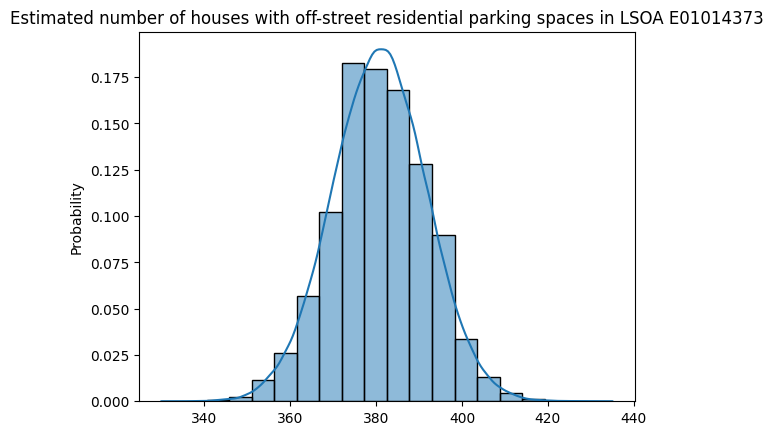

In [388]:
n_on_plot_parking = calculate_n_on_plot_parking(target_lsoa)

sns.histplot(n_on_plot_parking, bins=20, kde=True, stat='probability')
plt.title('Estimated number of houses with off-street residential parking spaces in LSOA {}'.format(target_lsoa))

Text(0.5, 1.0, 'Estimated proportion of houses with off-street residential parking spaces in LSOA E01014373')

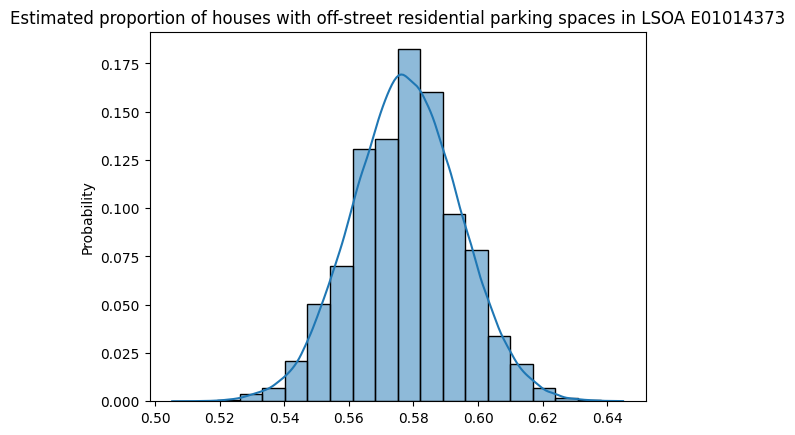

In [311]:
p_on_plot_parking = n_on_plot_parking/house_lsoa.loc[target_lsoa, 'N_households']

sns.histplot(p_on_plot_parking, bins=20, kde=True, stat='probability')
plt.title('Estimated proportion of houses with off-street residential parking spaces in LSOA {}'.format(target_lsoa))

The following tries to account for uncertainty in the English Housing Survey itself. 

However, it's difficult to justify a choice for a prior for the variance of the beta distribution that is assumed to describe the statsitics.

Until, the variance can be justified, this approach will be excluded from the analysis.

In [312]:
# n_on_plot_parking = np.empty(shape=[1000, 100])

# for i in range(0, 1000):

#     # Uncertainty in the English Housing Survey Statistics. 
#     # Assume that these statistics are distributed according to a beta distribution 
#     # The variance is arbitraty at the moment.

#     mu = on_plot_parking_availability_series.values
#     var = 0.05 * mu*(1-mu)

#     alpha = mu*(mu*(1-mu)/var - 1)
#     beta = (1-mu)*(mu*(1-mu)/var - 1)

#     # Assume a binomial distribution describes the spread of the likely numbers of houses of a given accommodation type with on-plot parking.

#     n = np.sum(
#         binom.rvs(
#             n=[accommodation_type_lsoa.loc[target_lsoa].loc[x].astype(int) for x in on_plot_parking_availability_series.index.values], 
#             p=stats.beta.rvs(a=alpha, b=beta).tolist(),
#             size=(100, 5)
#         ),
#         axis=1
#     )

#     n_on_plot_parking [i] = n

# n_on_plot_parking  = n_on_plot_parking .flatten()

# sns.histplot(n_on_plot_parking , kde=True, bins=50, alpha=0.3)
# plt.title('Estimated number of households with on-plot residential parking spaces in LSOA {}'.format(target_lsoa))

### Allocating Vehicles to on-plot parking spaces

In [314]:
target_lsoa_raw_census_cars_2021 = raw_census_cars_and_vans_2021_df[raw_census_cars_and_vans_2021_df['Lower Layer Super Output Areas Code'] == target_lsoa]
target_lsoa_raw_census_cars_2021

,Lower Layer Super Output Areas Code,Lower Layer Super Output Areas,Car or van availability (5 categories) Code,Car or van availability (5 categories),Observation,number_of_cars
68250,E01014373,Bath and North East Somerset 010A,-8,Does not apply,0,0
68251,E01014373,Bath and North East Somerset 010A,0,No cars or vans in household,99,0
68252,E01014373,Bath and North East Somerset 010A,1,1 car or van in household,315,315
68253,E01014373,Bath and North East Somerset 010A,2,2 cars or vans in household,187,374
68254,E01014373,Bath and North East Somerset 010A,3,3 or more cars or vans in household,58,174


In [315]:
# Proportion of households without a car
(target_lsoa_raw_census_cars_2021[target_lsoa_raw_census_cars_2021['Car or van availability (5 categories) Code'] == 0].Observation.iloc[0] /
    (census_cars_and_vans_2021_df.loc[target_lsoa, 'number_of_cars'] + 
     target_lsoa_raw_census_cars_2021[target_lsoa_raw_census_cars_2021['Car or van availability (5 categories) Code'] == 0].Observation.iloc[0]
    )
)

0.10291060291060292

In [316]:
# Mean cars per household (of houses that own at least 1 car)
if_car_how_many = (census_cars_and_vans_2021_df.loc[target_lsoa, 'number_of_cars'] /
    (house_lsoa.loc[target_lsoa, 'N_households'] - 
     target_lsoa_raw_census_cars_2021[target_lsoa_raw_census_cars_2021['Car or van availability (5 categories) Code'] == 0].Observation.iloc[0]
    )
)

if_car_how_many

1.5410714285714286

In [317]:
# Number of households with access to at least 1 car.
# (Estimated number of vehicles divided by the mean car-to-car-owning-household ratio)

households_with_car = registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'] * (1 + simulated_observations) / if_car_how_many
households_with_car

array([564.11175901, 620.6331144 , 557.42328599, ..., 645.37354272,
       562.30480114, 544.02387444])

In [318]:
len(households_with_car)

8000

In [319]:
np.random.choice(households_with_car, size=len(n_on_plot_parking))

array([550.09986219, 550.39012159, 518.90264905, ..., 546.21929761,
       583.80037808, 534.87083937])

<Axes: ylabel='Probability'>

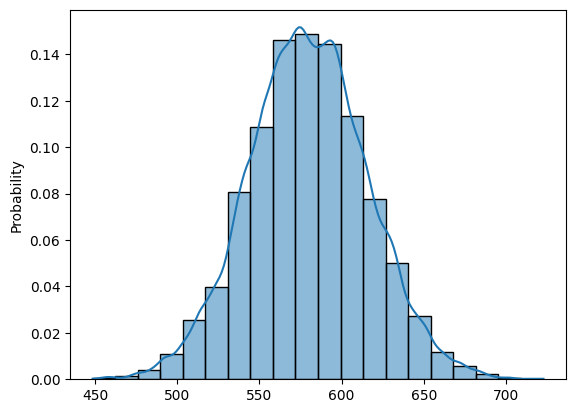

In [320]:
sns.histplot(
    np.random.choice(households_with_car, size=len(n_on_plot_parking)),
    bins=20,
    kde=True,
    stat='probability'
)

In [321]:
# Number of households with car access but without on-plot parking
np.clip(np.random.choice(households_with_car, size=len(n_on_plot_parking)) - n_on_plot_parking, a_min=0, a_max=None)

array([182.83851695, 260.42880891, 203.32515571, ..., 189.48506906,
       159.52142041, 206.42752636])

<Axes: ylabel='Probability'>

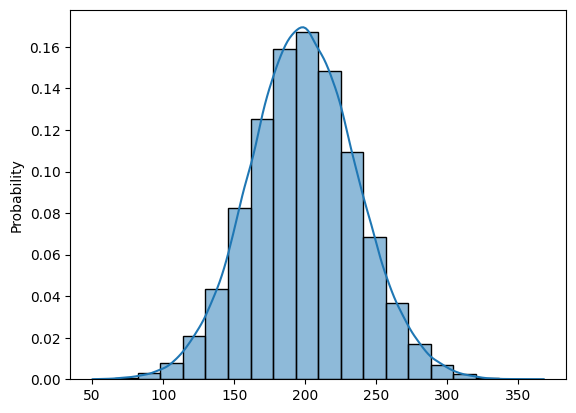

In [322]:
sns.histplot(
    np.clip(np.random.choice(households_with_car, size=len(n_on_plot_parking)) - n_on_plot_parking, a_min=0, a_max=None),
    bins=20,
    kde=True,
    stat='probability'
)

In [323]:
# Households with car access AND off-plot parking
np.clip(np.random.choice(households_with_car, size=len(n_on_plot_parking)), a_min=0, a_max=n_on_plot_parking)

array([393., 365., 386., ..., 372., 379., 361.])

<Axes: ylabel='Probability'>

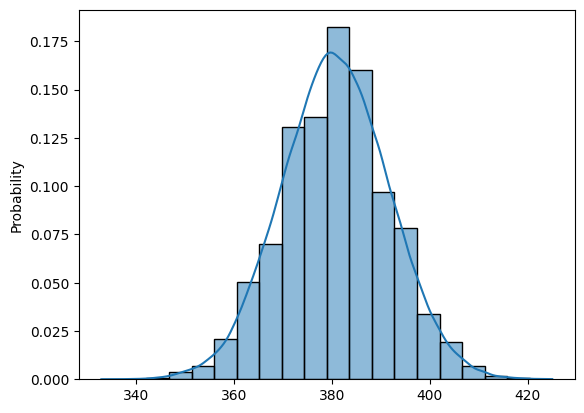

In [324]:
sns.histplot(
    np.clip(np.random.choice(households_with_car, size=len(n_on_plot_parking)), a_min=0, a_max=n_on_plot_parking),
    bins=20,
    kde=True,
    stat='probability'
)

In [325]:
# Proportion of households with car access AND off-plot parking
np.clip(np.random.choice(households_with_car, size=len(n_on_plot_parking)), a_min=0, a_max=n_on_plot_parking)/house_lsoa.loc[target_lsoa, 'N_households']

array([0.59635812, 0.5538695 , 0.58573596, ..., 0.56449165, 0.57511381,
       0.5477997 ])

<Axes: ylabel='Probability'>

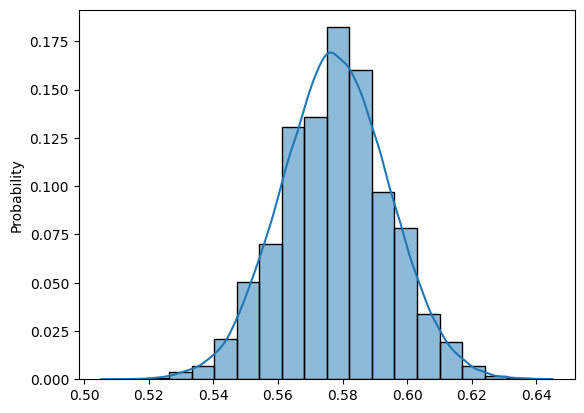

In [326]:
sns.histplot(
    np.clip(np.random.choice(households_with_car, size=len(n_on_plot_parking)), a_min=0, a_max=n_on_plot_parking)/house_lsoa.loc[target_lsoa, 'N_households'],
    bins=20,
    kde=True,
    stat='probability'
)

<Axes: ylabel='Probability'>

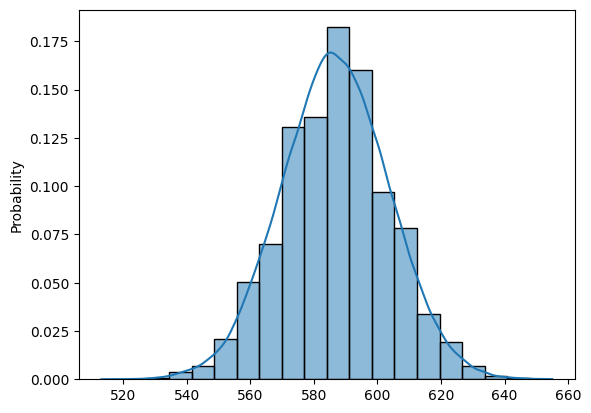

In [327]:
# Number of cars with on-plot parking access
sns.histplot(
    np.clip(np.random.choice(households_with_car, size=len(n_on_plot_parking)), a_min=0, a_max=n_on_plot_parking) * if_car_how_many,
    bins=20,
    kde=True,
    stat='probability'
)

In [328]:
census_cars_and_vans_2021_df.loc[target_lsoa, 'number_of_cars']

863

<Axes: ylabel='Probability'>

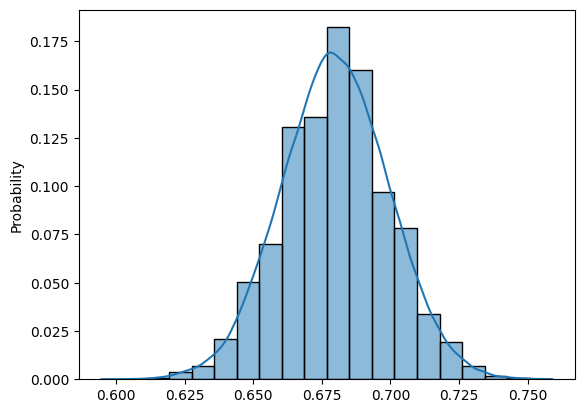

In [329]:
# Proportion of cars with on-plot parking access
sns.histplot(
    np.clip(
        np.clip(
            np.random.choice(
                households_with_car, 
                size=len(n_on_plot_parking)
            ), 
            a_min=0, 
            a_max=n_on_plot_parking
        ) * if_car_how_many / census_cars_and_vans_2021_df.loc[target_lsoa, 'number_of_cars'], 
        a_min=0, 
        a_max=1
    ),
    bins=20,
    kde=True,
    stat='probability'
)

In [389]:
def calculate_n_vehicles_with_on_plot_parking(target_lsoa, n_on_plot_parking):
    target_lsoa_raw_census_cars_2021 = raw_census_cars_and_vans_2021_df[raw_census_cars_and_vans_2021_df['Lower Layer Super Output Areas Code'] == target_lsoa]
    
    # Mean cars per household (of houses that own at least 1 car)
    if_car_how_many = (census_cars_and_vans_2021_df.loc[target_lsoa, 'number_of_cars'] /
        (house_lsoa.loc[target_lsoa, 'N_households'] - 
        target_lsoa_raw_census_cars_2021[target_lsoa_raw_census_cars_2021['Car or van availability (5 categories) Code'] == 0].Observation.iloc[0]
        )
    )

    # Number of households with access to at least 1 car.
    # (Estimated number of vehicles divided by the mean car-to-car-owning-household ratio)

    households_with_car = registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'] * (1 + simulated_observations) / if_car_how_many

    return np.clip(np.random.choice(households_with_car, size=len(n_on_plot_parking)), a_min=0, a_max=n_on_plot_parking) * if_car_how_many

In [390]:
calculate_n_vehicles_with_on_plot_parking(target_lsoa, calculate_n_on_plot_parking(target_lsoa))

array([584.06607143, 588.68928571, 608.72321429, ..., 588.68928571,
       605.64107143, 557.86785714])

<Axes: ylabel='Probability'>

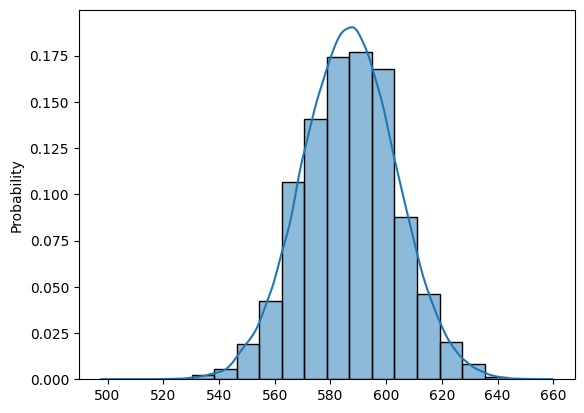

In [392]:
# Number of cars with on-plot parking access
sns.histplot(
    calculate_n_vehicles_with_on_plot_parking(target_lsoa, calculate_n_on_plot_parking(target_lsoa)),
    bins=20,
    kde=True,
    stat='probability'
)

### Allocating EVs to on-plot parking spaces

Currently, with the low levels of public charging infrastructure, prospective car buyers will be more likely to purchace an EV if they have on-plot parking access, thus guaranteeing them a charging point.

In [330]:
(bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)) / registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'] * (1 + simulated_observations)

array([0.01517997, 0.01837429, 0.01482214, ..., 0.0198684 , 0.01508288,
       0.01411811])

In [331]:
p_cars_on_plot_parking = np.clip(
    np.clip(
        np.random.choice(
            households_with_car, 
            size=len(n_on_plot_parking)
        ), 
        a_min=0, 
        a_max=n_on_plot_parking
    ) * if_car_how_many / census_cars_and_vans_2021_df.loc[target_lsoa, 'number_of_cars'], 
    a_min=0, 
    a_max=1
)
p_cars_on_plot_parking

array([0.70178571, 0.65178571, 0.68928571, ..., 0.66428571, 0.67678571,
       0.64464286])

In [332]:
np.linspace(0.9, p_cars_on_plot_parking, 100)

array([[0.9       , 0.9       , 0.9       , ..., 0.9       , 0.9       ,
        0.9       ],
       [0.89799784, 0.89749278, 0.89787157, ..., 0.89761905, 0.89774531,
        0.89742063],
       [0.89599567, 0.89498557, 0.89574315, ..., 0.8952381 , 0.89549062,
        0.89484127],
       ...,
       [0.70579004, 0.65680014, 0.69354257, ..., 0.66904762, 0.68129509,
        0.64980159],
       [0.70378788, 0.65429293, 0.69141414, ..., 0.66666667, 0.6790404 ,
        0.64722222],
       [0.70178571, 0.65178571, 0.68928571, ..., 0.66428571, 0.67678571,
        0.64464286]])

In [333]:
p_cars_on_plot_parking

array([0.70178571, 0.65178571, 0.68928571, ..., 0.66428571, 0.67678571,
       0.64464286])

In [345]:
mu = 0.9
var = 0.1 * mu*(1-mu)

alpha = mu*(mu*(1-mu)/var - 1)
beta = (1-mu)*(mu*(1-mu)/var - 1)

<Axes: ylabel='Count'>

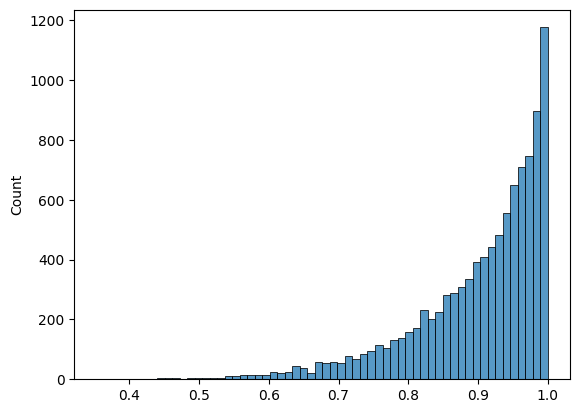

In [352]:
mu = 0.9
var = 0.1 * mu*(1-mu)

alpha = mu*(mu*(1-mu)/var - 1)
beta = (1-mu)*(mu*(1-mu)/var - 1)

sns.histplot(stats.beta.rvs(a=alpha, b=beta, size=10000))

In [357]:
def EVs_with_on_plot_parking_function(p_cars_on_plot_parking, mean_vehicles, n_evs):
    c = stats.beta.rvs(a=alpha, b=beta, size=len(n_on_plot_parking)) # y intercept
    m = (p_cars_on_plot_parking - c)/mean_vehicles # gradient
    p = m*n_evs + c
    return p

In [335]:
(bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)).mean()

13.43010823942205

In [336]:
np.random.choice(
    (bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)).round(0), 
    size=len(n_on_plot_parking)
)

array([14., 14., 15., ..., 11., 13., 14.])

In [358]:
EVs_with_on_plot_parking_function(
    p_cars_on_plot_parking, 
    (registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'] * (1 + simulated_observations)).mean(), 
    np.random.choice(
        (bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)).round(0), 
        size=len(n_on_plot_parking)
    )
)

array([0.86300927, 0.97258508, 0.89501759, ..., 0.90459659, 0.98441703,
       0.96521446])

<Axes: ylabel='Probability'>

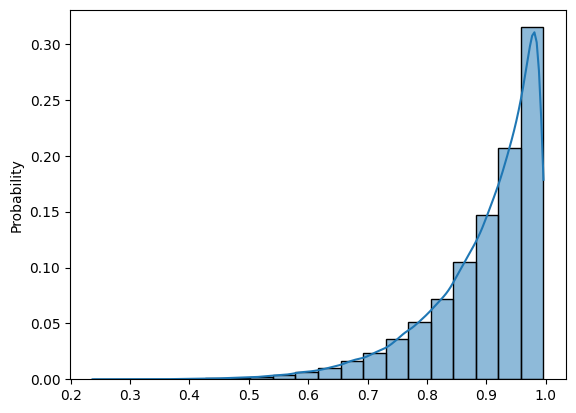

In [359]:
# Proportion of BEVs with on-plot parking access
sns.histplot(
    np.clip(
        EVs_with_on_plot_parking_function(
            p_cars_on_plot_parking, 
            (registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'] * (1 + simulated_observations)).mean(), 
            np.random.choice(
                (bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)).round(0), 
                size=len(n_on_plot_parking)
            )
        ),
        a_min=0, 
        a_max=1
    ),
    bins=20,
    kde=True,
    stat='probability'
)

In [381]:
(np.clip(
    EVs_with_on_plot_parking_function(
        p_cars_on_plot_parking, 
        (registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'] * (1 + simulated_observations)).mean(), 
        np.random.choice(
            (bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)).round(0), 
            size=len(n_on_plot_parking)
        )
    ),
    a_min=0, 
    a_max=1
) * np.random.choice(
        (bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)).round(0), 
        size=len(n_on_plot_parking)
    )
).round(0)

array([11., 12., 11., ...,  9., 10., 13.])

<Axes: ylabel='Probability'>

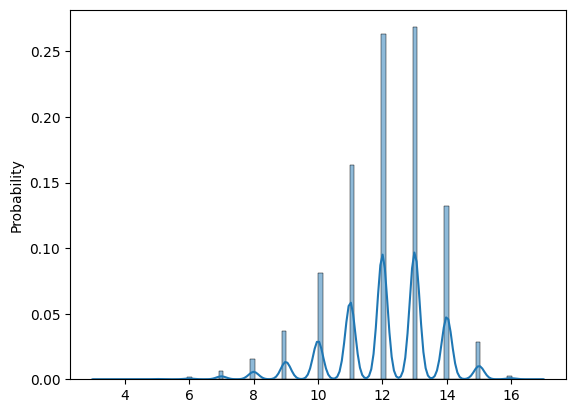

In [383]:
# Number of BEVs with access to on-plot parking
sns.histplot(
    (np.clip(
        EVs_with_on_plot_parking_function(
            p_cars_on_plot_parking, 
            (registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'] * (1 + simulated_observations)).mean(), 
            np.random.choice(
                (bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)).round(0), 
                size=len(n_on_plot_parking)
            )
        ),
        a_min=0, 
        a_max=1
    ) * np.random.choice(
            (bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)).round(0), 
            size=len(n_on_plot_parking)
        )
    ).round(0),
    bins=100,
    kde=True,
    stat='probability'
)

<Axes: ylabel='Probability'>

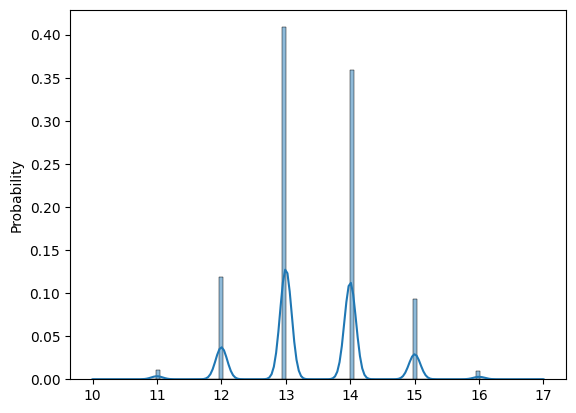

In [386]:
# Number of BEVs
sns.histplot(
    np.random.choice(
        (bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)).round(0), 
        size=len(n_on_plot_parking)
    ),
    bins=100,
    kde=True,
    stat='probability'
)